# Line Analysis
The goal is to implement a line analysis of the grid data in an effort to assess estimated posterior and hellinger distance between estimated and true posterior

In [1]:
# changing cwd
%cd ..

c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp


## Load packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle

cmap = 'PRGn'

# from celluloid import Camera

In [3]:
from src.inductive_bias import IB
ib = IB() #instantiate inductive bias package

[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\SimulationData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\PosteriorData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\TrainedCLF.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\EstimatedData.pickle ] loaded
[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\HellingerData.pickle ] loaded
Size of the S-XOR: (6322,)                    
Size of the Spiral: (6276,)                    
Size of the whole dataset: (12598, 7)

Size of the S-XOR after adding hellinger: (6322, 8)            
Size of the Spiral after adding hellinger: (6276, 8)


In [4]:
ib.load_sampledData()

[ c:\Users\jongm\Desktop\temp_workspace\Python\JOVO\induced_bias_exp\clf\SampledData.pickle ] loaded


## Time and Date of the experiment

In [5]:
print(ib.date)

2021-05-18 13:03:44.299222


In [6]:
#generic global
uX = ib.mask
uX0, uX1 = uX[:,0], uX[:,1]
label = ib.mtype[:3] + ['Human'] #excluding QDA
dtype = ib.dtype[2:5:2]
fsize = 18

#retrain global
reps = 126
saved_clf = ib.clf #using already optimized hyper-parameter from previous models
N_sample = 100 #same number of samples that of human
h = 0.1
rng = 3

#figure
SAVEFIG = False

In [7]:
from scipy.spatial import KDTree, cKDTree
import math

## Point-wise averaging and gaussian smoothing estimated posterior

In [8]:
mtype = []
ib.mask = ib.generate_mask(h=0.1)

for ii in range(2): #S-XOR and spiral
    mtype.append([])
    
    for jj in range(4):
        if jj == 3:
            mtype_i = np.column_stack([ib.human[ii][:,3], ib.human[ii][:,5], ib.human[ii][:,0]]) # human estimates
        else:
            mtype_i = ib.estpst_sample[ii][jj] # ML estimates        
        
        mtype_i = ib.pointwise_gridAverage(mtype_i).to_numpy()        
        xy, original, down, alls = ib.smooth_gaussian_distance(mtype_i, step=0.01, method=None, sigma=1, k=10)
        mtype[ii].append(alls)

In [293]:
# plt.scatter(mtype_i[:,0],mtype_i[:,1],c=mtype_i[:,2], cmap=cmap)
mtype_i.shape

(3098, 3)

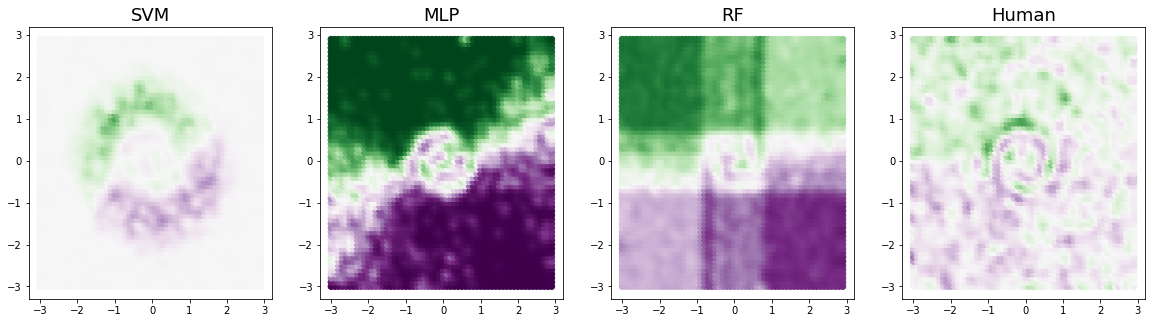

In [241]:
fig, axs = plt.subplots(1,4,figsize = (5*4,5))

for i in range(4):
    mlp = axs[i].scatter(ib.mask[:,0], ib.mask[:,1], c=mtype[0][i], cmap=cmap, vmin=0, vmax=1)
    axs[i].set_title(label[i], fontsize=18)

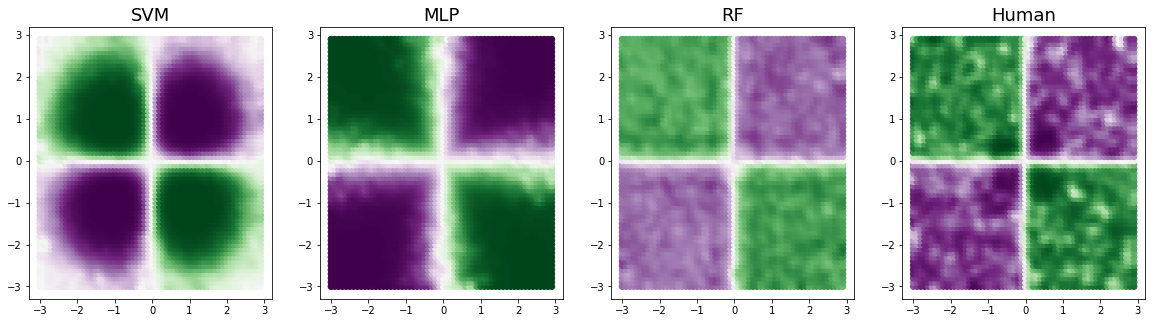

In [240]:
fig, axs = plt.subplots(1,4,figsize = (5*4,5))

for i in range(4):
    axs[i].scatter(ib.mask[:,0], ib.mask[:,1], c=mtype[1][i], cmap=cmap, vmin=0, vmax=1)
    axs[i].set_title(label[i], fontsize=18)

In [52]:
def select_linear_region(post, degree=0, b=0, r=0.1, step=0.1):
    '''
    r: radius of search parameter
    degree: degree of an angle
    b: y-intercept
    step: step of search w.r.t x-coordinate

    **uses current ib.mask to generate search tree
    '''
    
    tree = cKDTree(ib.mask) #putting [X,Y] coord. into scipy tree    
    theta = math.radians(degree)
    m = math.tan(theta)
    new_idx = set()
    i = 0
    end = True
    x = ib.mask[:,0].min() #left most X-coord
    x_r = ib.mask[:,0].max() #right most X-coord
    
    while end:
        i += 1 #counter for run-on

        y = m * x + b
        idx_p = tree.query_ball_point([x, y], r)

        if x > x_r:
            end = False

        if len(idx_p) == 0:
            x += step
            continue

        new_idx = new_idx.union(idx_p)

        x += step
    
    return post[list(new_idx)], list(new_idx)

In [249]:
line_plot = []
line_post = []
step = 0.2
r = 4
x_range = np.arange(-r,r,step)

for i in range(2):    
    line_plot.append([])
    line_post.append([])

    for j in range(4):
        line_plot[i].append([])
        line_post[i].append(select_linear_region(mtype[i][j], degree=135, step=0.01))
        
        lp, li = line_post[i][j] #line posterior, line index
        x = ib.mask[li][:,0]
        y = ib.mask[li][:,1]
        dist = np.sqrt(x**2 + y**2)

        dist[y < 0] *= -1 # negative radial distance wrt y-coordinate

        for rad in x_range:              
            line_plot[i][j].append(np.array(lp[(dist >= rad) * (dist < rad+step)]).mean())

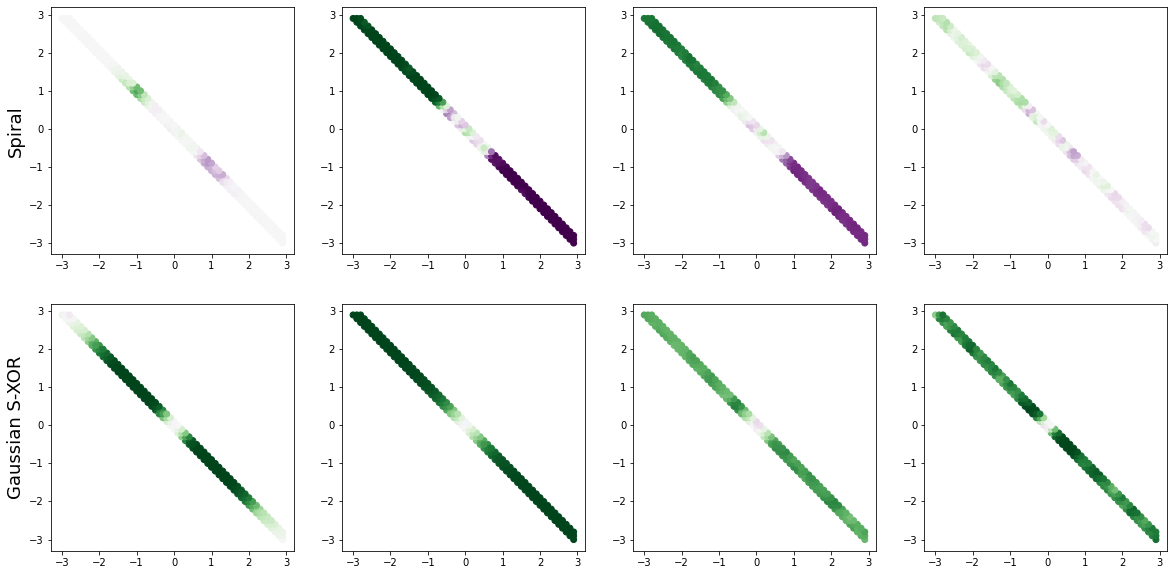

In [250]:
fig, axs = plt.subplots(2,4,figsize = (5*4,5*2))

for m in range(2):
    for i in range(4):
        ibXY = ib.mask[line_post[m][i][1]]
        # ibXY = np.vstack([ibXY, [[4,4],[-4,-4]]])
        axs[m,i].scatter(ibXY[:,0], ibXY[:,1], c=line_post[m][i][0], cmap=cmap, vmin=0, vmax=1)

        if i == 0:
            axs[m,i].set_ylabel(dtype[m], fontsize=18)

        # axs[m,i].set_xlim(-3,3)
        # axs[m,i].set_ylim(-3,3)

if SAVEFIG:
    plt.savefig(f'figs/[20210512_line_analysis]_posterior_{135}line_{str(ib.date.date())}.png', bbox_inches='tight')

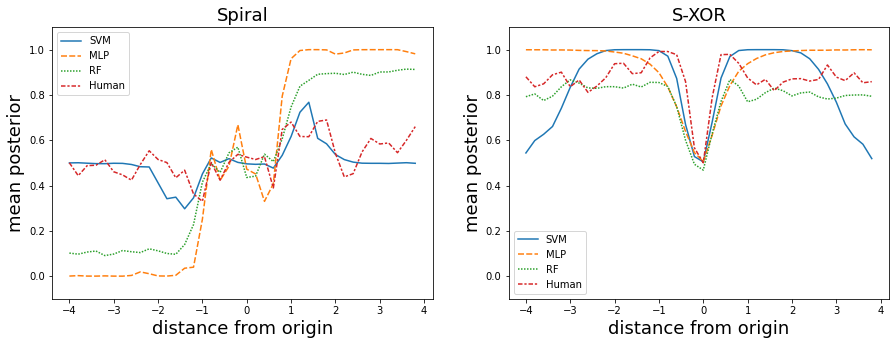

In [251]:
fig, axs = plt.subplots(1,2,figsize=(5*3,5))

for i in range(2):
    tempdf = pd.DataFrame(np.array(line_plot[i]).T, columns=label)
    tempdf.index = x_range
    sns.lineplot(data=tempdf, ax=axs[i])

    axs[i].set_title(['Spiral', 'S-XOR'][i], fontsize=18)
    axs[i].set_ylabel('mean posterior', fontsize=18)
    axs[i].set_xlabel('distance from origin', fontsize=18)
    axs[i].set_ylim([-0.1,1.1])

if SAVEFIG:
    plt.savefig(f'figs/[20210512_line_analysis]_posterior_{135}line_lineplot_{str(ib.date.date())}.png', bbox_inches='tight')